# Particle tracking with tracer

In [1]:
import numpy as np
from datetime import timedelta as delta, datetime
import xarray as xr
from parcels import FieldSet, Variable, ParticleSet, JITParticle, AdvectionRK4_3D, ErrorCode
import glob
import matplotlib.pyplot as plt

%matplotlib inline

#### Parameters

In [2]:
year = 2002

# Sub-domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179

#### Load files

In [3]:
# Open particle initialization location file:
ini_loc_PC = xr.open_dataset('/ocean/brogalla/GEOTRACES/parcels/Pb-chapter/western-PC-transect-parcels.nc')
PC_lons    = ini_loc_PC['longitude'].values
PC_lats    = ini_loc_PC['latitude'].values
PC_deps    = ini_loc_PC['depth'].values

# Open particle initialization location file:
ini_loc_GR = xr.open_dataset('/ocean/brogalla/GEOTRACES/parcels/Pb-chapter/Greenland-transect-parcels.nc')
GR_lons    = ini_loc_GR['longitude'].values
GR_lats    = ini_loc_GR['latitude'].values
GR_deps    = ini_loc_GR['depth'].values

#### General setup

Timestamps:

In [4]:
# Mesh mask
mesh_mask = '/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc'

# Lists of ANHA12 NEMO U,V,W files (on full ANHA12 domain)
folder_ANHA12      = '/data/brogalla/ANHA12/'
ANHA12_gridU_files = sorted(glob.glob(f'{folder_ANHA12}ANHA12-EXH006_y{year}m??d??_gridU.nc'))[0:40]
ANHA12_gridV_files = sorted(glob.glob(f'{folder_ANHA12}ANHA12-EXH006_y{year}m??d??_gridV.nc'))[0:40]
ANHA12_gridW_files = sorted(glob.glob(f'{folder_ANHA12}ANHA12-EXH006_5d_gridW_y{year}m??d??.nc'))[0:40]

# Lists of ANHA12 NEMO Pb tracer files (on sub-domain of full ANHA12 domain)
folder_Pb = f'/data/brogalla/run_storage/Pb-new-ini2-20220922/'
files_Pb  = sorted(glob.glob(f'{folder_Pb}ANHA12_EXH006_5d_{year}0101_{year}1231_ptrc_T_{year}*'))[0:40]

# Create timestamps from file dates: (because of time_origin issue in ANHA12 netcdf dynamics files)
time_stamps_files = []
for n, file in enumerate(ANHA12_gridU_files):
    dateU  = datetime.strptime(file[36:47],'y%Ym%md%d')
    dateV  = datetime.strptime(ANHA12_gridV_files[n][36:47],'y%Ym%md%d')
    dateW  = datetime.strptime(ANHA12_gridW_files[n][45:56],'y%Ym%md%d')
    datePb = datetime.strptime(files_Pb[n][99:107],'%Y%m%d')
    
    # double-check that the date is the same for all files
    if (dateU != dateV) | (dateU != dateW) | (dateU != datePb):
        print('Dates not equal!')
    else:   
        time_stamps_files.append(np.datetime64(f'{dateU.year:02}-{dateU.month:02}-{dateU.day:02}'))

# array of file timestamps
timestamps_files = np.expand_dims(np.array(time_stamps_files), axis=1)

Run with Pb as tracer (Pb on sub-domain, U,V,W on full domain)

In [5]:
filenames  = {'U': {'lon': mesh_mask   , 'lat': mesh_mask  , 'depth': ANHA12_gridW_files[0], 'data': ANHA12_gridU_files},
              'V': {'lon': mesh_mask   , 'lat': mesh_mask  , 'depth': ANHA12_gridW_files[0], 'data': ANHA12_gridV_files},
              'W': {'lon': mesh_mask   , 'lat': mesh_mask  , 'depth': ANHA12_gridW_files[0], 'data': ANHA12_gridW_files},
              'Pb': {'lon': files_Pb[0], 'lat': files_Pb[0], 'depth': files_Pb[0], 'data': files_Pb}}

dimensions = {'U': {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'depthw'},
              'V': {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'depthw'},
              'W': {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'depthw'},
              'Pb': {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'deptht'}}

variables  = {'U': 'vozocrtx',
              'V': 'vomecrty',
              'W': 'vovecrtz',
              'Pb': 'dissolpb'}

# needed to provide time as timestamps in order to avoid time origin type issue
fieldset   = FieldSet.from_nemo(filenames, variables, dimensions, \
                                timestamps=timestamps_files, \
                                allow_time_extrapolation=False)

#### General functions

In [6]:
def DeleteParticle(particle, fieldset, time):
    print("Particle [%d] lost !! (%g %g %g %g)" % (particle.id, particle.lon, particle.lat, particle.depth, particle.time))
    particle.delete()

In [7]:
# define new particle class for Pb
class PbParticle(JITParticle): 
    dissolvedPb = Variable('dissolpb', initial=0)  # Variable 'dissolpb' initialised by sampling the dissolved Pb field

In [8]:
def SamplePb(particle, fieldset, time):
    particle.dissolpb = fieldset.Pb[particle.time, particle.depth, particle.lat, particle.lon]

In [9]:
def pushback(particle, fieldset, time):
    particle.depth = 1. # 10.

In [10]:
def run_parcels(fieldset, plon, plat, pdepth, runtime=0, sampling=False, filename='test.zarr'):

    # Define particle locations on a grid in my domain:
    pset = ParticleSet(fieldset=fieldset, pclass=PbParticle, lon=plon, lat=plat, depth=pdepth)

    output_file = pset.ParticleFile(name=f"/ocean/brogalla/GEOTRACES/parcels/Pb-chapter/{filename}", 
                                    outputdt=delta(hours=12))

    # Nudge the particle set locations closer to the actual grid locations:               
    for i in range(len(pset)):
        for gi, g in enumerate(fieldset.gridset.grids):
            d = np.hypot((pset.lon[i] - g.lon), (pset.lat[i] - g.lat))
            ind = np.unravel_index(np.argmin(d, axis=None), d.shape)
            pset.xi[i, gi] = ind[1]
            pset.yi[i, gi] = ind[0]
    
    # Option to run with tracer sampling kernel (SamplePb) or only with 3D advection kernel
    if sampling:
        pset.execute(AdvectionRK4_3D + pset.Kernel(SamplePb), 
                     runtime = runtime, dt = delta(hours=2), 
                     output_file = output_file,
                     recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle, 
                               ErrorCode.ErrorThroughSurface: pushback})        
    else:
        pset.execute(AdvectionRK4_3D, runtime=runtime, dt=delta(hours=2),  
                     output_file = output_file,
                     recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle,
                               ErrorCode.ErrorThroughSurface: pushback})
    
    return pset

#### Run:

In [11]:
plon   = np.concatenate((PC_lons, GR_lons))
plat   = np.concatenate((PC_lats, GR_lats))
pdepth = np.concatenate((PC_deps, GR_deps))

In [ ]:
pset = run_parcels(fieldset, plon, plat, pdepth, runtime=delta(hours=24*30*6), 
                   sampling=True, filename='test2-20230202.zarr')

(54.0, 87.0)

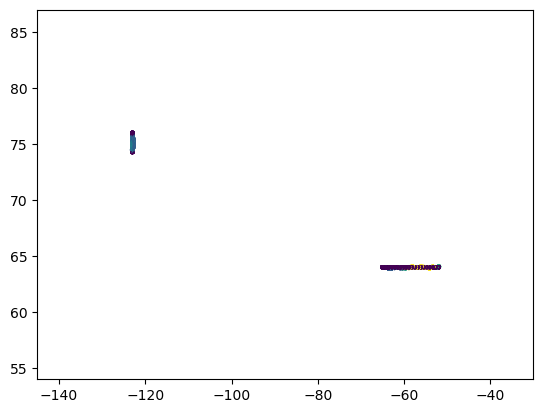

In [21]:
plt.scatter(pset.lon, pset.lat, s=5, c=pset.dissolpb, vmin=0, vmax=10e-12)
plt.xlim(-145,-30)
plt.ylim(54,87)

(63.0, 67.0)

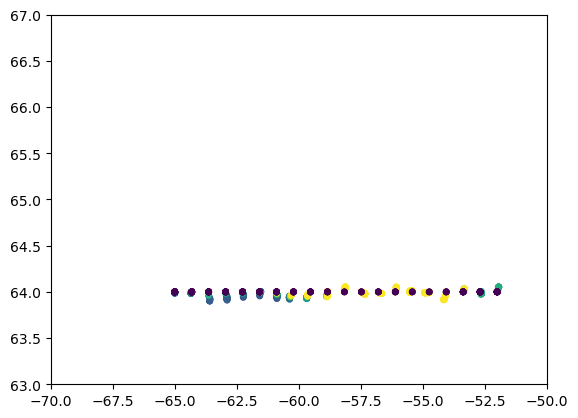

In [24]:
plt.scatter(pset.lon, pset.lat, s=15, c=pset.dissolpb, vmin=0, vmax=10e-12)
plt.xlim(-70,-50)
plt.ylim(63,67)

(72.0, 79.0)

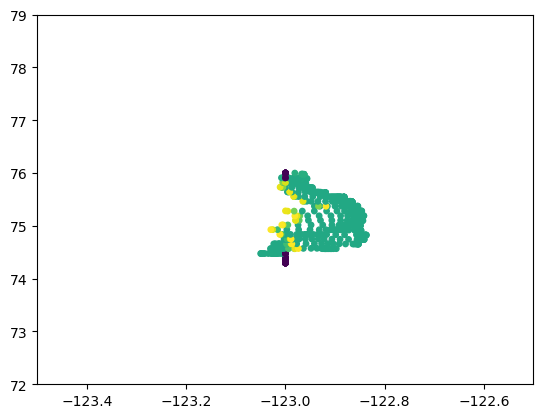

In [29]:
plt.scatter(pset.lon, pset.lat, s=15, c=pset.dissolpb, vmin=0, vmax=5e-12)
plt.xlim(-123.5,-122.5)
plt.ylim(72,79)